In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

2023-05-26 06:03:25.723253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 06:03:26.671147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-26 06:03:26.671261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [2]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 64


In [3]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 63 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [5]:
ner = pd.read_csv("gs://cloud-ai-platform-2e11e97a-0212-426c-b0fa-b1f124dd9ef2/entities_labels.csv")

In [6]:
ner.shape

(10846188, 4)

In [8]:
ner.head(20)

,Unnamed: 0,Index,Entities,Labels
0,0,0,Chinese,NORP
1,1,0,People Daily,ORG
2,2,0,March,DATE
3,3,0,Chinese,NORP
4,4,0,Liu Shiyao People Daily,ORG
5,5,0,March 2021Photo,DATE
6,6,0,July,DATE
7,7,0,ETC,ORG
8,8,0,Yangzhuang,GPE
9,9,0,Shijingshan,GPE


In [14]:
ner_org_person = ner[ner.Labels.isin(['PERSON','ORG'])]
ner_org_person.shape

(6729588, 4)

In [17]:
ner_org_person.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6729588 entries, 1 to 10846186
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   Index       int64 
 2   Entities    object
 3   Labels      object
dtypes: int64(2), object(2)
memory usage: 256.7+ MB


In [9]:
sentiment = pd.read_parquet("gs://cloud-ai-platform-2e11e97a-0212-426c-b0fa-b1f124dd9ef2/df_final.parquet")

In [10]:
sentiment = sentiment.reset_index()

In [33]:
sentiment['index'] = sentiment['index'].astype(str).astype(int)

In [34]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153517 entries, 0 to 153516
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   index      153517 non-null  int64 
 1   url        153517 non-null  object
 2   date       153517 non-null  int64 
 3   title      153517 non-null  object
 4   sentiment  153517 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.0+ MB


In [77]:
ner_with_sentiment = sentiment.merge(ner_org_person[['Index','Entities']], left_on = 'index', right_on = 'Index',how='inner')

In [78]:
ner_with_sentiment.head(2)

,index,url,date,title,sentiment,Index,Entities
0,0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,1616025600000,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,positive,0,People Daily
1,0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,1616025600000,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,positive,0,Liu Shiyao People Daily


In [75]:
ner_with_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5154305 entries, 0 to 5154304
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   index      int64         
 1   url        object        
 2   date       datetime64[ns]
 3   title      object        
 4   sentiment  object        
 5   Index      int64         
 6   Entities   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 314.6+ MB


In [79]:
ner_with_sentiment['date'] = pd.to_datetime(ner_with_sentiment['date'], unit='ms')

In [80]:
ner_with_sentiment.head(2)

,index,url,date,title,sentiment,Index,Entities
0,0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,positive,0,People Daily
1,0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,positive,0,Liu Shiyao People Daily


In [71]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [64]:
# To find companies with the most positive sentiment
companies_most_positive = ner_with_sentiment[ner_with_sentiment['sentiment'] == 'positive']['Entities'].value_counts().nlargest(200)

# To find companies with the most negative sentiment
companies_most_negative = ner_with_sentiment[ner_with_sentiment['sentiment'] == 'negative']['Entities'].value_counts().nlargest(200)


In [65]:
companies_most_positive = companies_most_positive.reset_index()

In [66]:
companies_most_positive = companies_most_positive[~companies_most_positive['index'].isin(['AI','Artificial Intelligence','Gray Media Group','Station Gray Television','The Associated Press','Artificial Intelligence AI'])]
companies_most_positive                                            
                                                  

,index,Entities
1,Google,41046
3,Microsoft,31863
4,ChatGPT,23436
6,GPT,13260
7,IBM,12804
...,...,...
195,CultureAll,888
196,Microsoft Azure,883
197,Artificial Intelligence Software,880
198,Automotive Artificial Intelligence,877


In [72]:
companies_most_positive

,index,Entities
1,Google,41046
3,Microsoft,31863
4,ChatGPT,23436
6,GPT,13260
7,IBM,12804
9,Amazon,10265
10,Bard,8846
11,Apple,7249
12,EU,6998
13,OpenAI,6723


In [67]:
companies_most_negative = companies_most_negative.reset_index()
companies_most_negative = companies_most_negative[~companies_most_negative['index'].isin(['AI','Artificial Intelligence','Gray Media Group','Station Gray Television','The Associated Press','Artificial Intelligence AI'])]
companies_most_negative                                            
                                                  

,index,Entities
1,Google,14544
3,Microsoft,11549
4,ChatGPT,8481
6,GPT,4668
7,IBM,4638
...,...,...
195,Darktrace,324
196,Altman,323
197,Microsoft Azure,317
198,ResourcesAll,317


In [94]:
pos = companies_most_positive['index']
neg = companies_most_negative['index']

only_neg = neg[~neg.isin(pos)]

print(only_neg)


117                                                      DoD
169                                                 Big Tech
175                                                Bloomberg
178    Artificial Intelligence Technology Opportunities Fund
185                                                       VR
186                                             Deepbrain AI
187                                                ReportThe
192                                             Kylie Jenner
193                                                     CCTV
194                                                 WhatsApp
195                                                Darktrace
199                                             Intelligence
Name: index, dtype: object


In [95]:
only_pos = pos[~pos.isin(neg)]
only_pos

146                             Ernie Bot
162                                    LG
172                                   BJP
174                                Martin
179                                    Q3
182                                 Lunit
183                             SafetyLit
187                                  Ford
195                            CultureAll
197      Artificial Intelligence Software
198    Automotive Artificial Intelligence
199          ServicesRadio Media Services
Name: index, dtype: object

In [73]:
companies_most_negative

,index,Entities
1,Google,14544
3,Microsoft,11549
4,ChatGPT,8481
6,GPT,4668
7,IBM,4638
9,Amazon,3594
10,Bard,3285
11,Apple,2688
12,EU,2385
13,OpenAI,2343


In [82]:
ner_with_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5154305 entries, 0 to 5154304
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   index      int64         
 1   url        object        
 2   date       datetime64[ns]
 3   title      object        
 4   sentiment  object        
 5   Index      int64         
 6   Entities   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 314.6+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



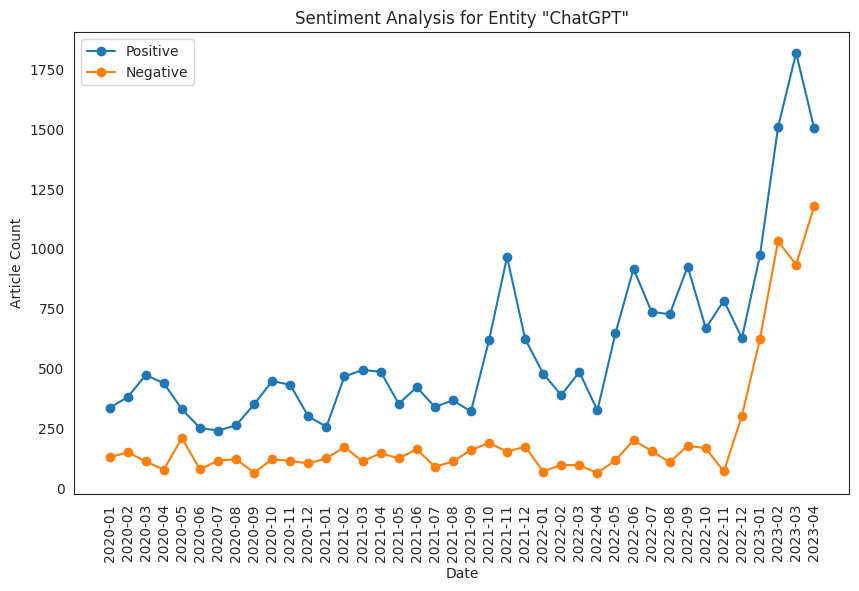

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe for the "chatGPT" entity
filtered_df = ner_with_sentiment[ner_with_sentiment['Entities'] == 'ChatGPT']

# Convert the 'date' column to datetime if it's not already
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Extract the month and year from the 'date' column
filtered_df['month_year'] = filtered_df['date'].dt.to_period('M')

# Group the data by month_year and sentiment, and calculate the count
grouped_df = filtered_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)

# Convert the index to string for x-axis labels
grouped_df.index = grouped_df.index.astype(str)

# Plot the graph
sns.set_style("white")
plt.figure(figsize=(10, 6))
x_ticks_labels = grouped_df.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.plot(x_ticks_positions, grouped_df['positive'], marker='o', label='Positive')
plt.plot(x_ticks_positions, grouped_df['negative'], marker='o', label='Negative')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Sentiment Analysis for Entity "ChatGPT"')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)
plt.legend()
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



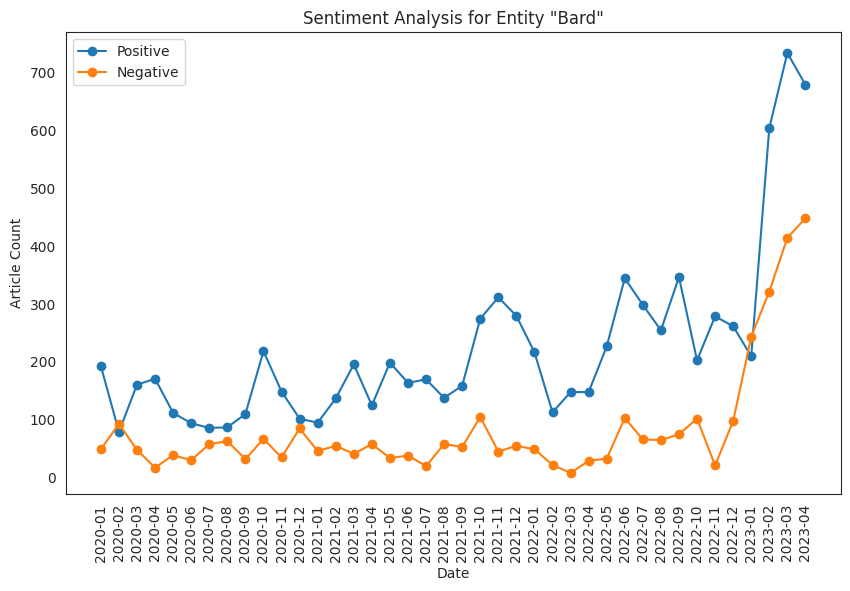

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe for the "chatGPT" entity
filtered_df = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Bard']

# Convert the 'date' column to datetime if it's not already
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Extract the month and year from the 'date' column
filtered_df['month_year'] = filtered_df['date'].dt.to_period('M')

# Group the data by month_year and sentiment, and calculate the count
grouped_df = filtered_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)

# Convert the index to string for x-axis labels
grouped_df.index = grouped_df.index.astype(str)

# Plot the graph
sns.set_style("white")
plt.figure(figsize=(10, 6))
x_ticks_labels = grouped_df.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.plot(x_ticks_positions, grouped_df['positive'], marker='o', label='Positive')
plt.plot(x_ticks_positions, grouped_df['negative'], marker='o', label='Negative')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Sentiment Analysis for Entity "Bard"')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)
plt.legend()
plt.show()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



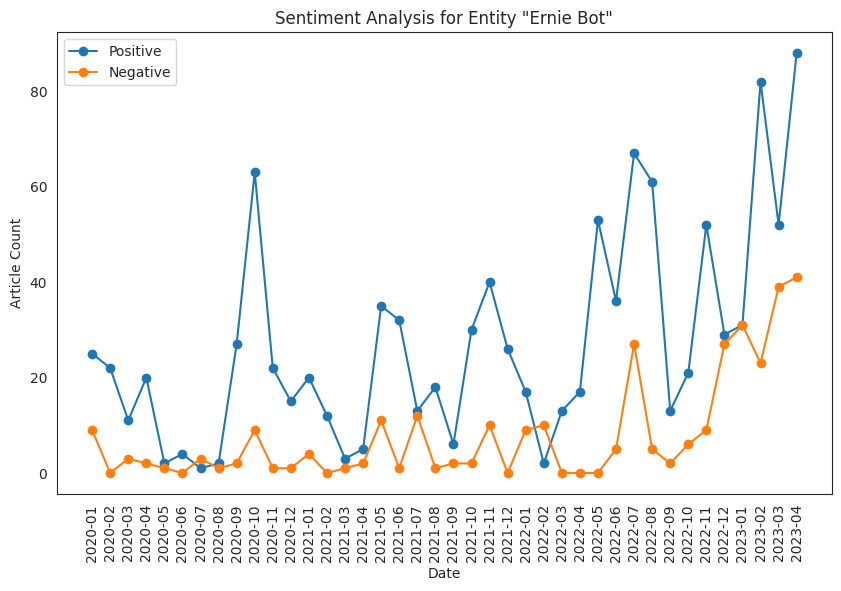

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe for the "chatGPT" entity
filtered_df = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Ernie Bot']

# Convert the 'date' column to datetime if it's not already
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Extract the month and year from the 'date' column
filtered_df['month_year'] = filtered_df['date'].dt.to_period('M')

# Group the data by month_year and sentiment, and calculate the count
grouped_df = filtered_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)

# Convert the index to string for x-axis labels
grouped_df.index = grouped_df.index.astype(str)

# Plot the graph
sns.set_style("white")
plt.figure(figsize=(10, 6))
x_ticks_labels = grouped_df.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.plot(x_ticks_positions, grouped_df['positive'], marker='o', label='Positive')
plt.plot(x_ticks_positions, grouped_df['negative'], marker='o', label='Negative')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Sentiment Analysis for Entity "Ernie Bot"')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)
plt.legend()
plt.show()




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



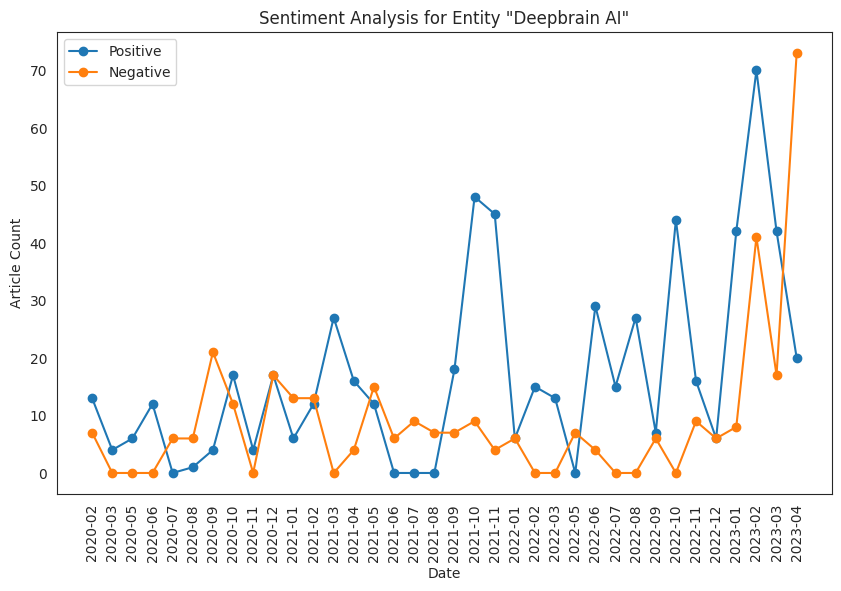

In [97]:

filtered_df = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Deepbrain AI']

# Convert the 'date' column to datetime if it's not already
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Extract the month and year from the 'date' column
filtered_df['month_year'] = filtered_df['date'].dt.to_period('M')

# Group the data by month_year and sentiment, and calculate the count
grouped_df = filtered_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)

# Convert the index to string for x-axis labels
grouped_df.index = grouped_df.index.astype(str)

# Plot the graph
sns.set_style("white")
plt.figure(figsize=(10, 6))
x_ticks_labels = grouped_df.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.plot(x_ticks_positions, grouped_df['positive'], marker='o', label='Positive')
plt.plot(x_ticks_positions, grouped_df['negative'], marker='o', label='Negative')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Sentiment Analysis for Entity "Deepbrain AI"')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)
plt.legend()
plt.show()





/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



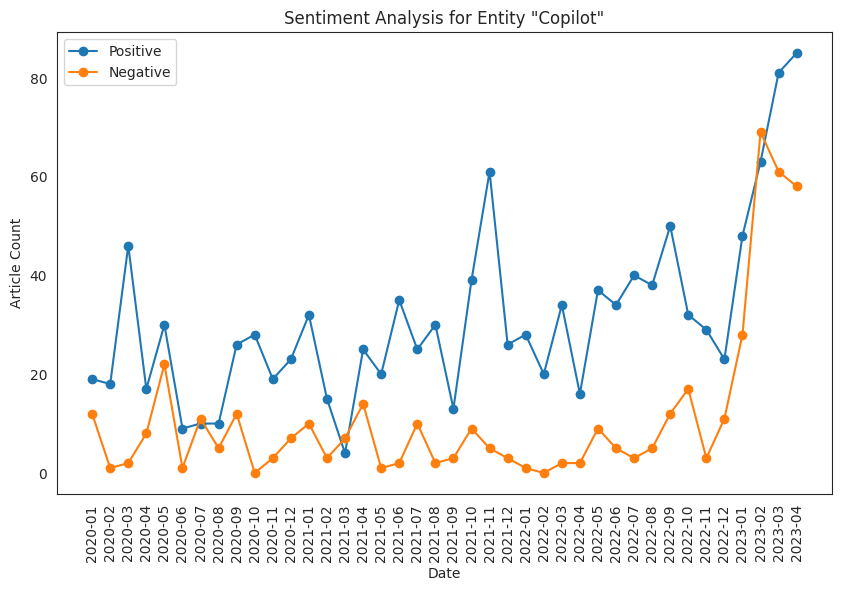

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe for the "chatGPT" entity
filtered_df = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Copilot']

# Convert the 'date' column to datetime if it's not already
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Extract the month and year from the 'date' column
filtered_df['month_year'] = filtered_df['date'].dt.to_period('M')

# Group the data by month_year and sentiment, and calculate the count
grouped_df = filtered_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)

# Convert the index to string for x-axis labels
grouped_df.index = grouped_df.index.astype(str)

# Plot the graph
sns.set_style("white")
plt.figure(figsize=(10, 6))
x_ticks_labels = grouped_df.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.plot(x_ticks_positions, grouped_df['positive'], marker='o', label='Positive')
plt.plot(x_ticks_positions, grouped_df['negative'], marker='o', label='Negative')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Sentiment Analysis for Entity "Copilot"')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)
plt.legend()
plt.show()





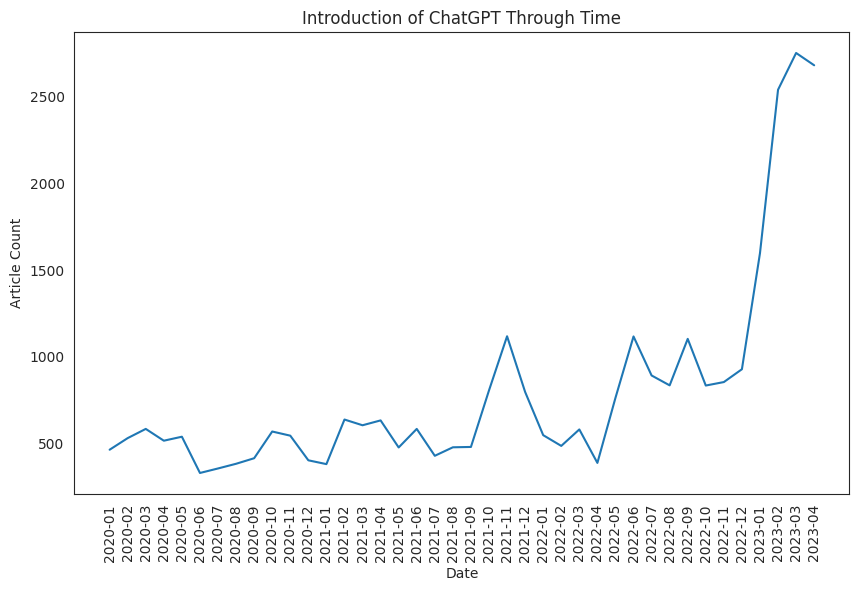

In [110]:

# Filter rows with entity "ChatGPT"
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'ChatGPT']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of ChatGPT Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()


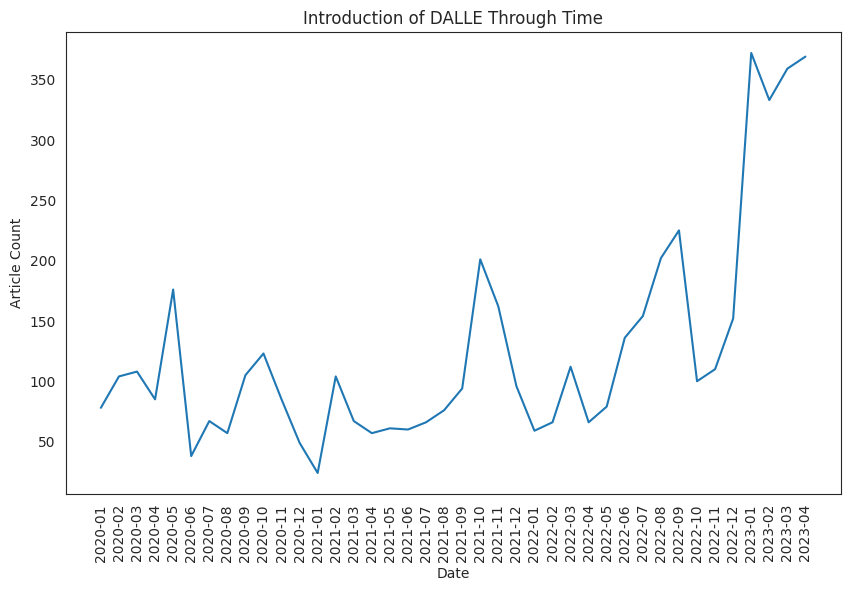

In [111]:
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'DALLE']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of DALLE Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()



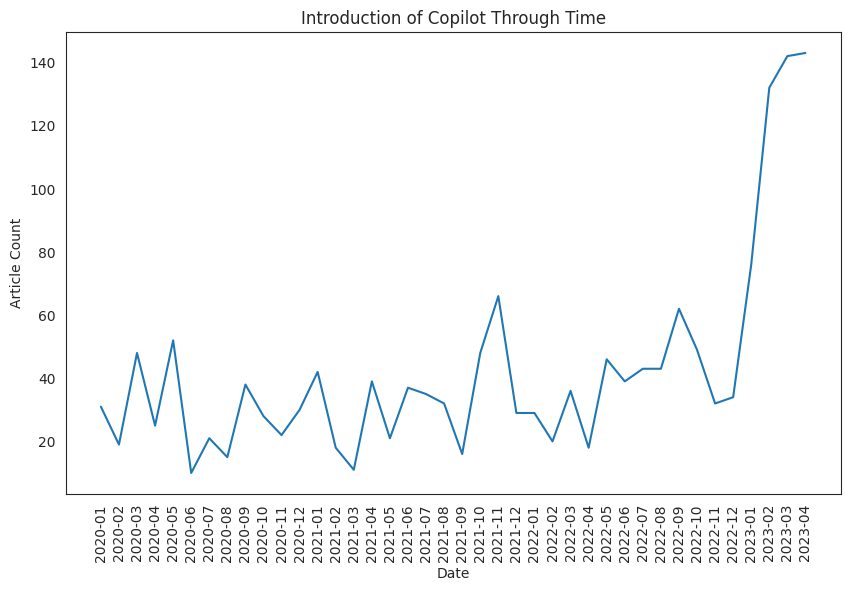

In [112]:

# Filter rows with entity "ChatGPT"
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Copilot']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of Copilot Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()




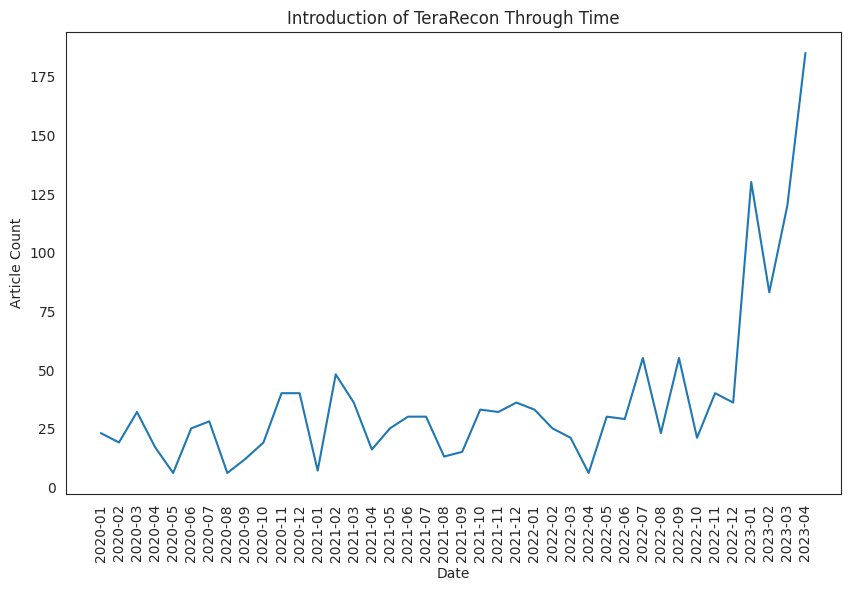

In [113]:

# Filter rows with entity "ChatGPT"
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'TeraRecon']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of TeraRecon Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()





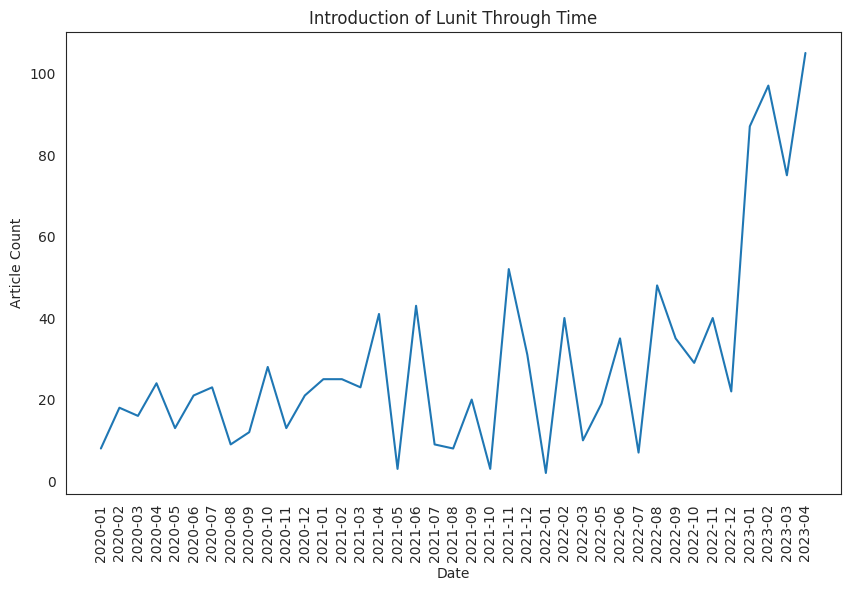

In [114]:

# Filter rows with entity "ChatGPT"
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Lunit']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of Lunit Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()






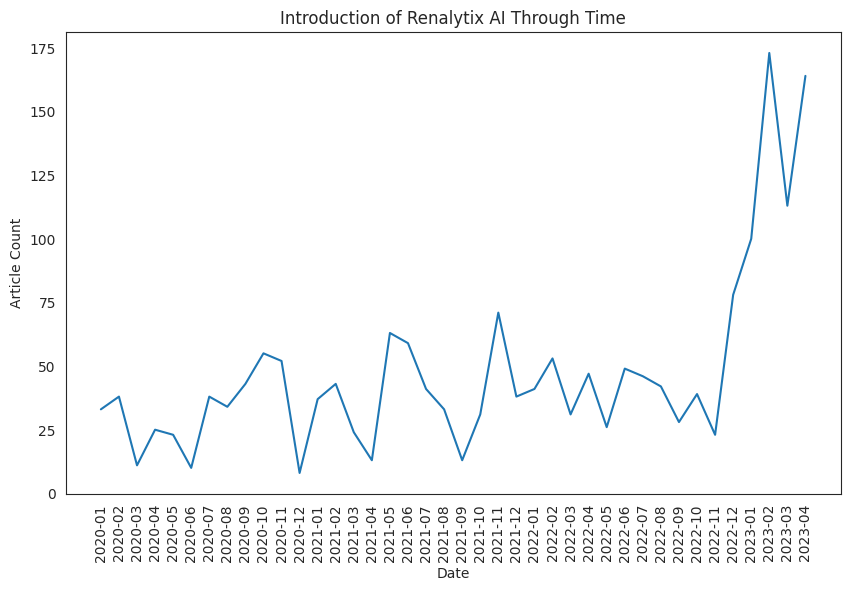

In [115]:

# Filter rows with entity "ChatGPT"
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Renalytix AI']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of Renalytix AI Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()






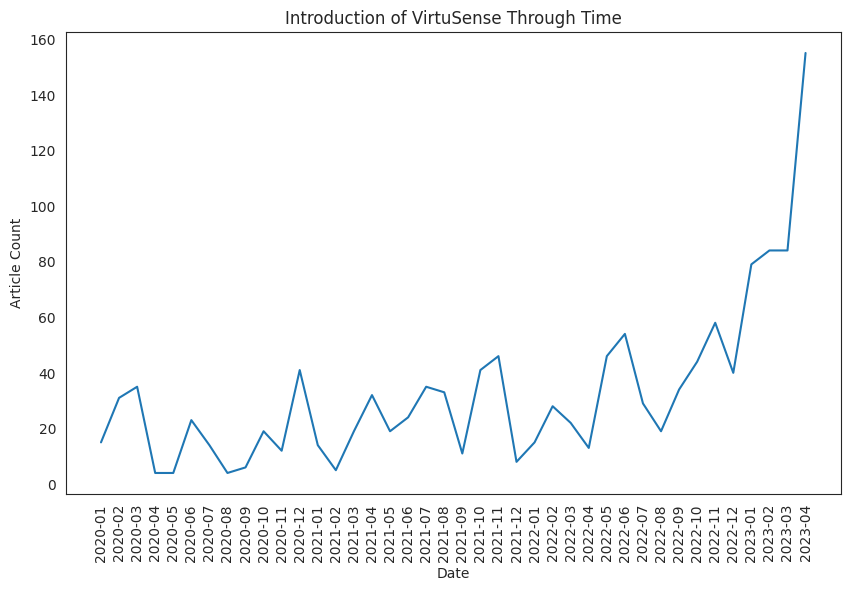

In [116]:

# Filter rows with entity "ChatGPT"
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Virtus']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of VirtuSense Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()







In [ ]:

# Filter rows with entity "ChatGPT"
df_chatgpt = ner_with_sentiment[ner_with_sentiment['Entities'] == 'Virtus']

# Group by month and date, and count the rows
count_per_month = df_chatgpt.groupby(df_chatgpt['date'].dt.to_period('M')).size()

# Plot the count
x_ticks_labels = count_per_month.index.tolist()
x_ticks_positions = range(len(x_ticks_labels))
plt.figure(figsize=(10, 6))
plt.plot(x_ticks_positions,count_per_month)

plt.xlabel('Date')
plt.ylabel('Article Count')
plt.title('Introduction of VirtuSense Through Time')
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=90)


plt.show()
plt.show()






